In [3]:
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from pylab import rcParams
from sgp4.api import Satrec, jday, days2mdhms
from kamodo_ccmc.flythrough.utils import ConvertCoord
import functions_1 as fn

r_e = 6371.
sl_list = pd.read_pickle('starlink_epop_2023.pkl')
list_dir = os.listdir('spectrogram_pickles')

In [17]:
def spec_plot(pkl_dir):
    print(pkl_dir)
    df_in = pd.read_pickle(pkl_dir)
    dt_list = np.array(df_in.index)
    freq_bins = np.array(df_in.columns)
    fft_array = df_in.to_numpy().T
    
    rcParams['figure.figsize'] = 20, 5
    spec_plot = plt.contourf(dt_list, freq_bins, fft_array, levels=np.linspace(-20,30,10), norm = Normalize(vmin = -30, vmax = 30), cmap = 'jet')
    plt.colorbar(spec_plot)
    plt.show()
    return

In [4]:
sl_list

,id,name
2022-04-08 23:10:15,48372,STARLINK-2572
2022-04-12 09:00:47,48021,STARLINK-2301
2022-04-12 10:19:21,52111,STARLINK-3708
2022-04-12 12:21:14,47979,STARLINK-2325
2022-04-12 20:23:24,47765,STARLINK-2183
2022-04-13 21:25:32,52103,STARLINK-3705
2022-04-13 23:25:05,45076,STARLINK-1180
2022-06-09 10:45:00,46027,STARLINK-1522
2022-11-26 18:49:20,45755,STARLINK-1478
2023-03-13 22:34:30,55399,STARLINK-5276


In [55]:
sl_id = 9
buffer_sec = 360

conj_time = sl_list.index[sl_id]
sta = pd.to_datetime(conj_time-timedelta(seconds=buffer_sec))
end = pd.to_datetime(conj_time+timedelta(seconds=buffer_sec))

j_conj_time = fn.julian(conj_time)[0]
j_sta = j_conj_time - buffer_sec/86400
j_end = j_conj_time + buffer_sec/86400
j_range = np.arange(j_sta, j_end, 1/86400)[:2*buffer_sec]

sat_ts = np.arange(int(sta.timestamp()),int(end.timestamp()))

sat_id = sl_list['id'].iloc[sl_id]
configpath = './SpTrack-2.ini'
ts_buffer = 2 # in days
ts_e1 = conj_time.round('d') - timedelta(days=ts_buffer)
ts_e2 = conj_time.round('d') + timedelta(days=ts_buffer)

sat_tle = fn.tle_select(fn.findTLE(sat_id, ts_e1, ts_e2, configpath), j_conj_time)
r_sat = np.zeros((len(j_range),3))
for i in range(len(j_range)):
    r_sat[i,:] = Satrec.twoline2rv(sat_tle.iloc[0][0], sat_tle.iloc[1][0]).sgp4(j_range[i],0)[1]

sx_teme, sy_teme, sz_teme = (r_sat/r_e).T
sx, sy, sz = ConvertCoord(sat_ts, sx_teme, sy_teme, sz_teme, 'teme', 'car', 'GSE', 'car', verbose=False)[:-1]
sx*=r_e
sy*=r_e
sz*=r_e

epop_tle = fn.tle_select(fn.findTLE(39265, ts_e1, ts_e2, configpath), j_conj_time)
r_epop = np.zeros((len(j_range),3))
for i in range(len(j_range)):
    r_epop[i,:] = Satrec.twoline2rv(epop_tle.iloc[0][0], epop_tle.iloc[1][0]).sgp4(j_range[i],0)[1]

ex_teme, ey_teme, ez_teme = (r_epop/r_e).T
ex, ey, ez = ConvertCoord(sat_ts, ex_teme, ey_teme, ez_teme, 'teme', 'car', 'GSE', 'car', verbose=False)[:-1]
ex*=r_e
ey*=r_e
ez*=r_e

min_dist = np.min(np.sum((np.stack((sx,sy,sz),axis=1)-np.stack((ex,ey,ez),axis=1))**2,axis=1)**0.5)
conj_index = np.argmin(np.sum((np.stack((sx,sy,sz),axis=1)-np.stack((ex,ey,ez),axis=1))**2,axis=1)**0.5)
label_index = np.argmin(abs(sat_ts - conj_time.timestamp()))

conj_dt = datetime.utcfromtimestamp(sat_ts[conj_index])

lon, lat, alt = ConvertCoord(sat_ts[conj_index], ex_teme[conj_index], ey_teme[conj_index], ez_teme[conj_index], 'teme', 'car', 'GDZ', 'sph', verbose=False)[:-1]

print('NORAD CAT ID:', sat_id)
print('Satellite name:', sl_list['name'].iloc[sl_id])
print('TCA:', conj_dt)
print('Minimum distance:', round(min_dist, 1), 'km')

NORAD CAT ID: 55399
Satellite name: STARLINK-5276
TCA: 2023-03-13 22:37:20
Minimum distance: 33.7 km


spectrogram_pickles\spec_20230313_223444_223941_a.pkl


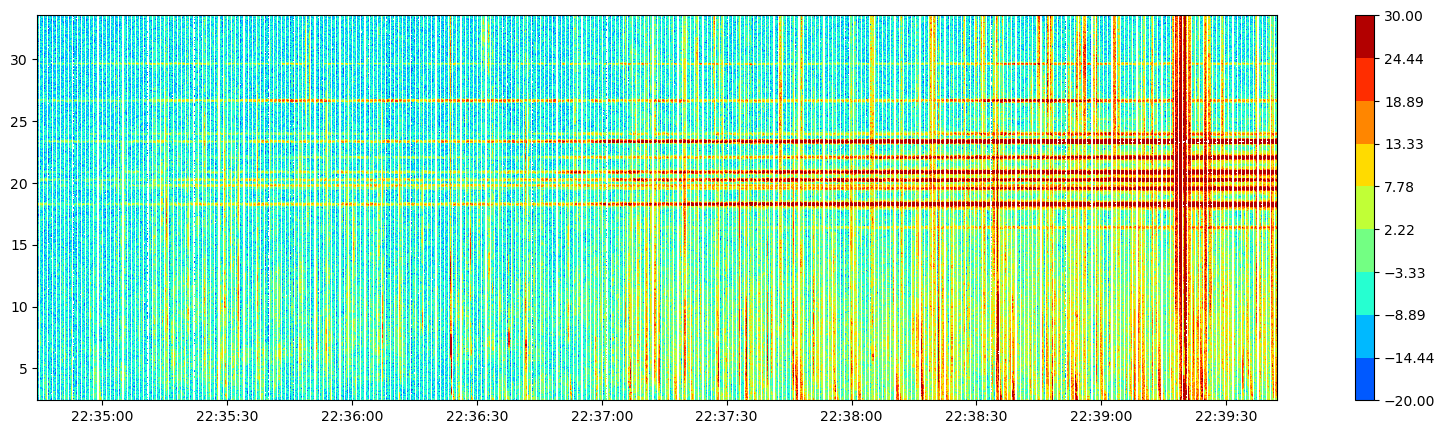

spectrogram_pickles\spec_20230313_223444_223941_b.pkl


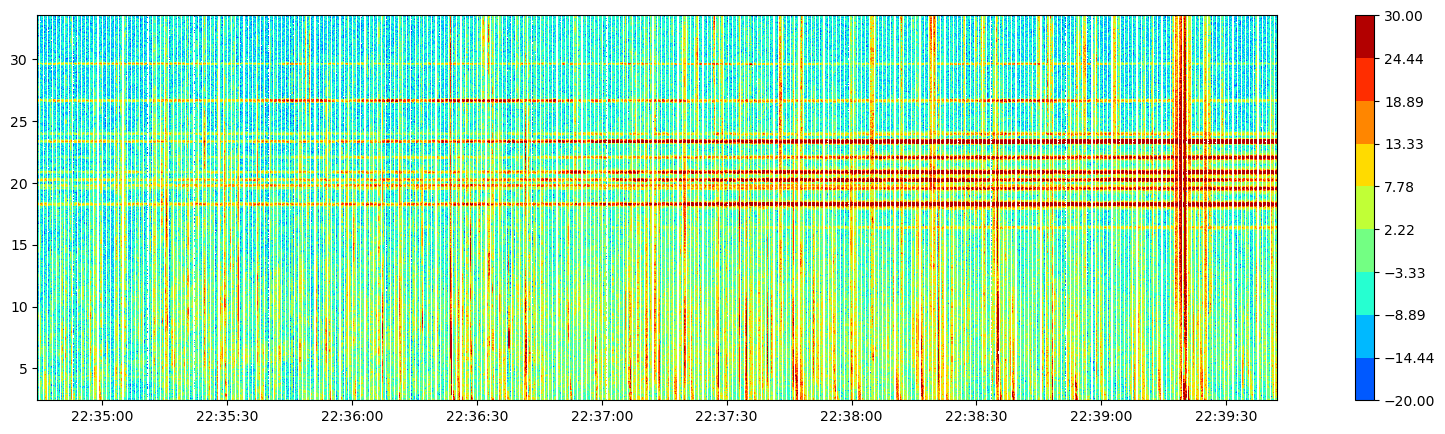

In [56]:
dt_str = str(conj_time.date()).replace('-','') + '_' + str(conj_time.time())[:2]
a = [os.path.join('spectrogram_pickles',i) for i in list_dir if dt_str in i]
for i in a:
    spec_plot(i)